# Market Regime Forecasting with Hidden Markov  

This notebook explores the use of Hidden Markov models to classify market into two hidden states: bull or bear regimes.  

Three different fitting approaches have been used to train the model: Static-Window Fitting, Expanding-Window Fitting and Walk-Forward Fitting.  

Finally, we use only the testing period between 2018-2022 for backtesting to check the profitability for each of these three approaches.

In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import math
import talib as tal
import ta
import statsmodels.api as sm
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import pyfolio as pyf

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Enter ticker symbol here
ticker = 'SPY'


# Read historical price data for ticker
filepath = f'./datasets/{ticker}.csv'
asset = pd.read_csv(filepath)
asset['Date'] = pd.to_datetime(asset['Date'])
asset.set_index('Date', inplace=True)


In [3]:
def create_ma(asset_df, window):
    """
    Add a column for Moving Average for the specified rolling window
    """
    asset_df[f'ma_{window}'] = asset_df['ADJ CLOSE'].rolling(window).mean()
    
    # Calculate log_return of the moving average price series
    asset_df[f'ma_{window}_log_return'] = np.log(asset_df[f'ma_{window}']/asset_df[f'ma_{window}'].shift(1))   

In [4]:
def create_ta(asset_df):
    """
    Creates column of Technical Analysis Indicators from either ta-lib or ta libraries
    """
    # Calculate Average Directional Value
    asset_df['ADX'] = tal.ADX(asset_df['HIGH'], asset_df['LOW'], asset_df['CLOSE'])
    # Calculate Commodity Channel Index
    asset_df['CCI'] = tal.CCI(asset_df['HIGH'], asset_df['LOW'], asset_df['CLOSE'])
    # Calculate Relative Strength Index
    asset_df['RSI'] = tal.RSI(asset_df['CLOSE'])
    # Calculate Mass Index
    asset_df['MASS_INDEX'] = ta.trend.mass_index(asset_df['HIGH'], asset_df['LOW'])
    # Calculate Donchian Channel index
    asset_df['DONCHIAN'] = ta.volatility.DonchianChannel(asset_df['HIGH'], asset_df['LOW'], asset_df['CLOSE']).donchian_channel_pband()
    # Calculate 1-Month returns
    asset_df['1M_RETURNS'] = (asset_df['ADJ CLOSE'].pct_change()+1).rolling(21).apply(lambda x: x.prod())-1
    # Calculate 3-Month returns
    asset_df['3M_RETURNS'] = (asset_df['ADJ CLOSE'].pct_change()+1).rolling(64).apply(lambda x: x.prod())-1

In [53]:
def plot_hidden_states(hidden_states, prices_df):
    '''
    Input:
    hidden_states(numpy.ndarray) - array of predicted hidden states
    prices_df(df) - dataframe of close prices
    
    Output:
    Graph showing hidden states and prices
    '''
    
    colors = ['blue','red']
    n_components = len(np.unique(hidden_states))
    fig = go.Figure()
    
    for i in range(n_components):
        mask = hidden_states == i 
        print('Number of observations for State', i, ':', len(prices_df.index[mask]))
        
        fig.add_trace(go.Scatter(x=prices_df.index[mask], y=prices_df['ADJ CLOSE'][mask],
                                mode='markers', name='Hidden State' + str(i), marker=dict(size=4, color=colors[i])))
        
    fig.update_layout(height=600, width=1000, legend=
                      dict(yanchor='top', y=0.99, xanchor='left', x=0.01), margin=dict(l=20, r=20, t=20, b=20)).show()

In [54]:
def switch_labels_and_plot(asset_df, hidden_states, start_year, end_year):
    """
    As the hidden states are randomly labeled by the HiddenMarkov model, we want to reassign the labels such that:
    
    :hidden_state_0 = bull market (blue color)
    :hidden_state_1 = bear market (red color)
    
    Once labels are correctly reassigned, the chart will be plotted and the correct hidden_states output will be returned for analysis
    
    """
    # Where necessary, switch hidden state labels first
    sliced_asset_df = asset_df.copy().loc[str(start_year):str(end_year)]
    sliced_asset_df['regime'] = hidden_states
    for year in np.arange(start_year, end_year+1):
        regime_0_mean_returns = sliced_asset_df.loc[str(year)].groupby('regime')['1M_RETURNS'].mean()[0]
        regime_1_mean_returns = sliced_asset_df.loc[str(year)].groupby('regime')['1M_RETURNS'].mean()[1]
        if regime_1_mean_returns > regime_0_mean_returns:
            sliced_asset_df.loc[str(year), 'regime'] = np.where(sliced_asset_df.loc[str(year), 'regime']==1.0, 0.0, 1.0)
    
    # Plot the hidden states with the price history
    plot_hidden_states(sliced_asset_df['regime'], sliced_asset_df)
    
    # Returns corrected hidden state labels
    return sliced_asset_df['regime']

In [7]:
# Create the columns of technical indicators
create_ta(asset)
asset

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS
Date,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218233,1003200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397585,480500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451389,201300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720436,529400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828053,531500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,16.092604,111.093208,59.739623,24.785164,0.927547,0.052793,0.092184
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,16.652488,98.696199,59.230404,24.622421,0.906596,0.036170,0.100237
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,16.406721,72.892540,59.360537,24.576825,0.912315,0.051560,0.074537


In [8]:
# Check number of NaNs
asset.isnull().sum()

OPEN           0
HIGH           0
LOW            0
CLOSE          0
ADJ CLOSE      0
VOLUME         0
ADX           27
CCI           13
RSI           14
MASS_INDEX    40
DONCHIAN      19
1M_RETURNS    21
3M_RETURNS    64
dtype: int64

In [9]:
# Drop rows with NaNs (since they are very few)
asset.dropna(inplace=True)
asset.isnull().sum()

OPEN          0
HIGH          0
LOW           0
CLOSE         0
ADJ CLOSE     0
VOLUME        0
ADX           0
CCI           0
RSI           0
MASS_INDEX    0
DONCHIAN      0
1M_RETURNS    0
3M_RETURNS    0
dtype: int64

In [10]:
# Training HiddenMarkov model on the FULL dataset

# Select features to fit model on
X = np.array(asset[['ADX', 'CCI', 'RSI', 'MASS_INDEX', 'DONCHIAN', '1M_RETURNS', '3M_RETURNS']].values)

print("fitting to HMM and decoding ...", end="")

model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000).fit(X)

hidden_states = model.predict(X)

print('Transition matrix')
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()
    

fitting to HMM and decoding ...

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Transition matrix
[[0.95741717 0.04258283]
 [0.04875884 0.95124116]]

Means and vars of each hidden state
0th hidden state
mean =  [2.19729144e+01 8.34959395e+01 6.22450829e+01 2.44978664e+01
 8.44927101e-01 3.67840057e-02 5.92440557e-02]
var =  [6.89380592e+01 4.60037023e+03 4.51921943e+01 1.00072168e+00
 1.79089201e-02 7.66221501e-04 3.38378757e-03]

1th hidden state
mean =  [ 2.36278633e+01 -4.89523175e+01  4.51413156e+01  2.55568687e+01
  3.83824043e-01 -2.31138649e-02 -1.07730379e-02]
var =  [6.31997929e+01 9.16064881e+03 5.91069448e+01 1.73926934e+00
 5.97243938e-02 1.78118877e-03 5.99201770e-03]



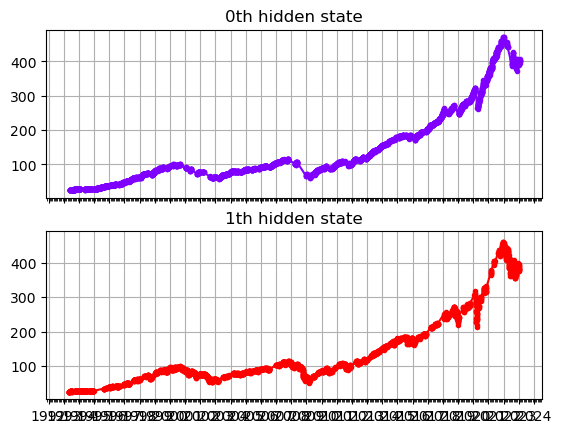

In [11]:
# Plotting the hidden states as generated by the model

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = hidden_states == i 
    ax.plot_date(asset.index[mask], asset['ADJ CLOSE'][mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))
    
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    
    ax.grid(True)
    
plt.show()

# Static Window Model Fitting

We designate a static period between 1993-2009 for model fitting. The trained model will then be tested for its predictability during the testing period between 2010-2023/1. Finally, model performance will be backtested for profitability for the period 2018-2023/1.

In [44]:
# Splitting the dataset into train and test set - find the index to split on first
split_index = np.where(asset.index > '2010-01-01')[0][0]   
print(split_index)


4200


In [45]:
# Select features to fit model on
X = np.array(asset[['ADX', 'RSI', 'MASS_INDEX', 'DONCHIAN', '1M_RETURNS', '3M_RETURNS']].values)   # removed 'CCI' as it is asset-dependent indicator

# Splitting the dataset into train and test set using the split_index
train_X = X[:split_index]
val_X = X[split_index:]


In [46]:
asset[:split_index]

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,regime,SW_val_regimes,EW_val_regimes,WF_val_regimes
Date,,,,,,,,,,,,,,,,,
1993-05-03,44.093750,44.312500,43.906250,44.312500,25.553581,80500,26.154337,-15.150025,48.976197,25.622208,0.550000,-1.596101e-02,0.013298,NaN,NaN,NaN,NaN
1993-05-04,44.406250,44.625000,44.343750,44.468750,25.643688,149100,25.730673,40.596206,51.633782,25.548165,0.633333,8.504950e-03,0.009690,1.0,NaN,NaN,NaN
1993-05-05,44.468750,44.750000,44.468750,44.593750,25.715754,109000,24.945331,69.905533,53.710930,25.560623,0.700000,6.346364e-03,0.010387,1.0,NaN,NaN,NaN
1993-05-06,44.531250,44.562500,44.406250,44.437500,25.625660,54700,24.362171,57.616893,50.775484,25.489994,0.616667,5.657712e-03,-0.003685,1.0,NaN,NaN,NaN
1993-05-07,44.468750,44.468750,44.281250,44.343750,25.571592,68000,24.112678,47.863248,49.043558,25.361100,0.566667,2.220446e-16,-0.009930,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-24,112.190002,112.599998,112.000000,112.480003,87.790802,39677500,9.905031,133.021101,60.998894,23.205780,0.973215,1.888073e-02,0.076903,0.0,NaN,0.0,0.0
2009-12-28,112.900002,112.989998,112.320000,112.720001,87.978088,87508500,10.302690,133.748563,62.061832,23.060617,0.944559,1.747910e-02,0.084987,0.0,NaN,0.0,0.0
2009-12-29,113.010002,113.029999,112.550003,112.559998,87.853203,80572500,10.701450,123.007401,60.870736,22.962950,0.882793,3.281888e-02,0.064390,0.0,NaN,0.0,0.0


In [47]:
# Fitting the model on train and predicting on test

print("fitting to HMM and decoding ...", end="")

# Specify n_components=2 for 2 hidden_states representing bull and bear regimes
model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000).fit(train_X)


# Predict the hidden states for both training and validation sets
train_hidden_states = model.predict(train_X)
val_hidden_states = model.predict(val_X)

print('Transition matrix')
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

fitting to HMM and decoding ...

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Transition matrix
[[0.95546317 0.04453683]
 [0.05021537 0.94978463]]

Means and vars of each hidden state
0th hidden state
mean =  [2.27328986e+01 6.13636070e+01 2.46718512e+01 8.25408088e-01
 3.70638547e-02 5.98941581e-02]
var =  [8.06894578e+01 4.81610733e+01 7.82889629e-01 1.85631862e-02
 8.96052725e-04 4.06447896e-03]

1th hidden state
mean =  [ 2.41152327e+01  4.45283419e+01  2.53582787e+01  3.61365017e-01
 -2.59674141e-02 -2.04951073e-02]
var =  [6.57641994e+01 5.38979424e+01 1.21061914e+00 5.39778424e-02
 1.76364651e-03 6.63518732e-03]



In [55]:
# Plotting the hidden states in the training set
train_hidden_states = switch_labels_and_plot(asset, train_hidden_states, 1993, 2009)

Number of observations for State 0 : 2230
Number of observations for State 1 : 1970


In [56]:
# Plotting the hidden states in the validation set
val_hidden_states = switch_labels_and_plot(asset, val_hidden_states, 2010, 2023)

Number of observations for State 0 : 1914
Number of observations for State 1 : 1376


In [19]:
# Concat both train_hidden_states and val_hidden_states
combined_hidden_states = pd.concat([train_hidden_states, val_hidden_states], axis=0) 

# Append the hidden_states to asset df as a target column for binary classification modeling
asset['regime'] = combined_hidden_states

# Append SW_val_hidden_states to asset df (test period: 2018-2023/1)
SW_val_hidden_states =  pd.Series(val_hidden_states, index=asset.loc['2018':'2023'].index)
asset['SW_val_regimes'] = SW_val_hidden_states
asset

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,regime,SW_val_regimes
Date,,,,,,,,,,,,,,,
1993-05-03,44.093750,44.312500,43.906250,44.312500,25.553581,80500,26.154337,-15.150025,48.976197,25.622208,0.550000,-1.596101e-02,0.013298,1,NaN
1993-05-04,44.406250,44.625000,44.343750,44.468750,25.643688,149100,25.730673,40.596206,51.633782,25.548165,0.633333,8.504950e-03,0.009690,1,NaN
1993-05-05,44.468750,44.750000,44.468750,44.593750,25.715754,109000,24.945331,69.905533,53.710930,25.560623,0.700000,6.346364e-03,0.010387,1,NaN
1993-05-06,44.531250,44.562500,44.406250,44.437500,25.625660,54700,24.362171,57.616893,50.775484,25.489994,0.616667,5.657712e-03,-0.003685,1,NaN
1993-05-07,44.468750,44.468750,44.281250,44.343750,25.571592,68000,24.112678,47.863248,49.043558,25.361100,0.566667,2.220446e-16,-0.009930,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,16.092604,111.093208,59.739623,24.785164,0.927547,5.279339e-02,0.092184,0,0.0
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,16.652488,98.696199,59.230404,24.622421,0.906596,3.617016e-02,0.100237,0,0.0
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,16.406721,72.892540,59.360537,24.576825,0.912315,5.156021e-02,0.074537,0,0.0


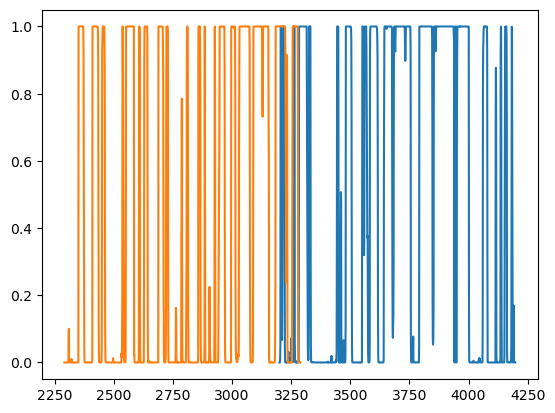

In [20]:
# Extract the log probabilities of bear market from the training period
train_log_proba = model.score_samples(train_X)[1]
train_bear_proba = train_log_proba[:, 1]
pd.Series(train_bear_proba)[-1000:-1].plot();


# Export training dataset to csv for further modeling
asset_train = asset.copy().loc[:'2009'][['ADJ CLOSE', 'ADX','CCI','RSI','MASS_INDEX','DONCHIAN','1M_RETURNS','3M_RETURNS','regime']]
asset_train['bear_proba'] = train_bear_proba
asset_train.to_csv('./datasets/asset_train.csv', index=True)



# Extract the log probabilities of bear market from the testing period
val_log_proba = model.score_samples(val_X)[1]
val_bear_proba = val_log_proba[:, 1]
pd.Series(val_bear_proba)[-1000:-1].plot();


# Export testing dataset to csv for further modeling
asset_test = asset.copy().loc['2010':][['ADJ CLOSE', 'ADX','CCI','RSI','MASS_INDEX','DONCHIAN','1M_RETURNS','3M_RETURNS','regime']]
asset_test['bear_proba'] = val_bear_proba
asset_test.to_csv('./datasets/asset_test.csv', index=True)

# Expanding Window Model Fitting

We will now try to fit our model on an accumulating training period instead of a static window.  

With each year passed, the past year of data is added into our training dataset for a fresh model fitting. This trained model will then be used to predict on next year's data as the testing period. This cumulative process continues on until the end of our available dataset 2023/1.  

All the yearly test predictions are concatenated for plotting against the actual market. Likewise, only the period 2018-2023/1 will then be backtested for profitability.

In [21]:
combined_val_hidden_states = []

for year in np.arange(1993,2023):
    train_X = np.array(asset.loc[:str(year)][['ADX', 'RSI', 'MASS_INDEX', 'DONCHIAN', '1M_RETURNS', '3M_RETURNS']].values)
    val_X = np.array(asset.loc[str(year+1)][['ADX', 'RSI', 'MASS_INDEX', 'DONCHIAN', '1M_RETURNS', '3M_RETURNS']].values)

    model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000).fit(train_X)
    
    # Predicting on the following year's features 
    print(f"Predicting {year+1} regimes...")
    val_hidden_states = model.predict(val_X)
    combined_val_hidden_states = np.append(combined_val_hidden_states, val_hidden_states)


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Predicting 1994 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Predicting 1995 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



Predicting 1996 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



Predicting 1997 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 1998 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.



Predicting 1999 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.



Predicting 2000 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2001 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2002 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2003 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2004 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2005 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2006 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2007 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2008 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2009 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2010 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2011 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2012 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2013 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2014 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2015 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2016 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2017 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2018 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2019 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2020 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2021 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2022 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Predicting 2023 regimes...


In [22]:
# Plotting the hidden states in the validation period (1995-onwards)
EW_val_hidden_states = switch_labels_and_plot(asset, combined_val_hidden_states, 1994, 2023)

# As expected, the prediction accuracy was very bad at the start (since it was fitted on very little data)
# However, as the training period expands, the accuracy of the predicted regimes was improved.

Number of observations for State 0 : 3229
Number of observations for State 1 : 4091


In [23]:
# Append EW_val_hidden_states to asset df
asset['EW_val_regimes'] = EW_val_hidden_states
asset

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,regime,SW_val_regimes,EW_val_regimes
Date,,,,,,,,,,,,,,,,
1993-05-03,44.093750,44.312500,43.906250,44.312500,25.553581,80500,26.154337,-15.150025,48.976197,25.622208,0.550000,-1.596101e-02,0.013298,1,NaN,NaN
1993-05-04,44.406250,44.625000,44.343750,44.468750,25.643688,149100,25.730673,40.596206,51.633782,25.548165,0.633333,8.504950e-03,0.009690,1,NaN,NaN
1993-05-05,44.468750,44.750000,44.468750,44.593750,25.715754,109000,24.945331,69.905533,53.710930,25.560623,0.700000,6.346364e-03,0.010387,1,NaN,NaN
1993-05-06,44.531250,44.562500,44.406250,44.437500,25.625660,54700,24.362171,57.616893,50.775484,25.489994,0.616667,5.657712e-03,-0.003685,1,NaN,NaN
1993-05-07,44.468750,44.468750,44.281250,44.343750,25.571592,68000,24.112678,47.863248,49.043558,25.361100,0.566667,2.220446e-16,-0.009930,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,16.092604,111.093208,59.739623,24.785164,0.927547,5.279339e-02,0.092184,0,0.0,0.0
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,16.652488,98.696199,59.230404,24.622421,0.906596,3.617016e-02,0.100237,0,0.0,0.0
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,16.406721,72.892540,59.360537,24.576825,0.912315,5.156021e-02,0.074537,0,0.0,0.0


# Walk-Forward Model Fitting

The third approach uses a rolling 5-year window as the training period. The primary advantage of this approach is to allow our model to be able to react on subtle changes in the underlying market regime by training it on only the last five years of data.   
With each year passed, the 5-year rolling window is rolled forward to include the year just passed while the first year is dropped. The newly trained model is then used to predict on the following year's test data.  

All the yearly test predictions are concatenated for plotting against the actual market. Likewise, only the period 2018-2023/1 will then be backtested for profitability.  

(Unfortunately, this training approach resulted in the worst negative performance for the backtested strategy due to large number of false positive signals from the 2H2020 onwards resulting in large losses.)

In [24]:
combined_val_hidden_states = []

for year in np.arange(1993,2023):    
    train_X = np.array(asset.loc[str(year):str(year+4)][['ADX', 'RSI', 'MASS_INDEX', 'DONCHIAN', '1M_RETURNS', '3M_RETURNS']].values)
    val_X = np.array(asset.loc[str(year+5)][['ADX', 'RSI', 'MASS_INDEX', 'DONCHIAN', '1M_RETURNS', '3M_RETURNS']].values)
    
    model = GaussianHMM(n_components=2, covariance_type='full', n_iter=1000, random_state=0).fit(train_X)
    
    # Predicting on the following year's features 
    print(f"Predicting {year+5} regimes...")
    val_hidden_states = model.predict(val_X)
    combined_val_hidden_states = np.append(combined_val_hidden_states, val_hidden_states)
    
    
# Note: ignore KeyError as there is no data for year 2024

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 1998 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 1999 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2000 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2001 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2002 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2003 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2004 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2005 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2006 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2007 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2008 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2009 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2010 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2011 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2012 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2013 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2014 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2015 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2016 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2017 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2018 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2019 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2020 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2021 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2022 regimes...


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



Predicting 2023 regimes...


KeyError: '2024'

In [25]:
# Plotting the hidden states in the validation period (1995-onwards)
WF_val_hidden_states = switch_labels_and_plot(asset, combined_val_hidden_states, 1998, 2023)

# Walk-forward fitting yields more accurate preds consistently as it adapts to a rolling 5-year market conditions
# Notably, it was able to capture correctly classify nearly all of 2022 year as a bearish year despite its intense volatility which the previous two approaches overlooked.

Number of observations for State 0 : 2885
Number of observations for State 1 : 3424


In [26]:
# Append WF_val_hidden_states to asset df
asset['WF_val_regimes'] = WF_val_hidden_states
asset

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,regime,SW_val_regimes,EW_val_regimes,WF_val_regimes
Date,,,,,,,,,,,,,,,,,
1993-05-03,44.093750,44.312500,43.906250,44.312500,25.553581,80500,26.154337,-15.150025,48.976197,25.622208,0.550000,-1.596101e-02,0.013298,1,NaN,NaN,NaN
1993-05-04,44.406250,44.625000,44.343750,44.468750,25.643688,149100,25.730673,40.596206,51.633782,25.548165,0.633333,8.504950e-03,0.009690,1,NaN,NaN,NaN
1993-05-05,44.468750,44.750000,44.468750,44.593750,25.715754,109000,24.945331,69.905533,53.710930,25.560623,0.700000,6.346364e-03,0.010387,1,NaN,NaN,NaN
1993-05-06,44.531250,44.562500,44.406250,44.437500,25.625660,54700,24.362171,57.616893,50.775484,25.489994,0.616667,5.657712e-03,-0.003685,1,NaN,NaN,NaN
1993-05-07,44.468750,44.468750,44.281250,44.343750,25.571592,68000,24.112678,47.863248,49.043558,25.361100,0.566667,2.220446e-16,-0.009930,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,16.092604,111.093208,59.739623,24.785164,0.927547,5.279339e-02,0.092184,0,0.0,0.0,0.0
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,16.652488,98.696199,59.230404,24.622421,0.906596,3.617016e-02,0.100237,0,0.0,0.0,0.0
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,16.406721,72.892540,59.360537,24.576825,0.912315,5.156021e-02,0.074537,0,0.0,0.0,0.0


In [27]:
# As the daily regime prediction is only made after the day's session has ended, the signals generated today are in fact for tomorrow's use
# So we need to shift all the regime preds by +1 period for backtesting on yesterday's signals, and not today's signals

asset[['regime', 'SW_val_regimes', 'EW_val_regimes', 'WF_val_regimes']] = asset[['regime', 'SW_val_regimes', 'EW_val_regimes', 'WF_val_regimes']].shift(1)

# Export final asset df to csv for further modeling
asset.to_csv(f"regime_filter.csv")

In [28]:
asset

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,ADX,CCI,RSI,MASS_INDEX,DONCHIAN,1M_RETURNS,3M_RETURNS,regime,SW_val_regimes,EW_val_regimes,WF_val_regimes
Date,,,,,,,,,,,,,,,,,
1993-05-03,44.093750,44.312500,43.906250,44.312500,25.553581,80500,26.154337,-15.150025,48.976197,25.622208,0.550000,-1.596101e-02,0.013298,NaN,NaN,NaN,NaN
1993-05-04,44.406250,44.625000,44.343750,44.468750,25.643688,149100,25.730673,40.596206,51.633782,25.548165,0.633333,8.504950e-03,0.009690,1.0,NaN,NaN,NaN
1993-05-05,44.468750,44.750000,44.468750,44.593750,25.715754,109000,24.945331,69.905533,53.710930,25.560623,0.700000,6.346364e-03,0.010387,1.0,NaN,NaN,NaN
1993-05-06,44.531250,44.562500,44.406250,44.437500,25.625660,54700,24.362171,57.616893,50.775484,25.489994,0.616667,5.657712e-03,-0.003685,1.0,NaN,NaN,NaN
1993-05-07,44.468750,44.468750,44.281250,44.343750,25.571592,68000,24.112678,47.863248,49.043558,25.361100,0.566667,2.220446e-16,-0.009930,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800,16.092604,111.093208,59.739623,24.785164,0.927547,5.279339e-02,0.092184,0.0,0.0,0.0,0.0
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900,16.652488,98.696199,59.230404,24.622421,0.906596,3.617016e-02,0.100237,0.0,0.0,0.0,0.0
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300,16.406721,72.892540,59.360537,24.576825,0.912315,5.156021e-02,0.074537,0.0,0.0,0.0,0.0


## Backtesting Profitability for Test Period 2018-2023/1

### 1. Backtest Results for Static-Window Model Fitting

In [29]:
# Read in backtest results csv file
filepath = f'./datasets/backtest_results/HMM_market_regimes_predictions_SW_backtest.csv'
backtest = pd.read_csv(filepath)

backtest.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
backtest['Date'] = pd.to_datetime(backtest.Date)
backtest.set_index('Date', inplace=True)
backtest

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,forecast,ideal_pos,close,fill_size,fill_price,total_buy,total_sell,average_buy_price,average_sell_price,unrealized_pnl,realized_pnl,total_pnl
Date,,,,,,,,,,,,,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,246.766617,86655700.0,0,0,246.766617,0,0.000000,0,0,0.000000,0.00000,0.000000,0.000000,0.000000
2018-01-03,268.959991,270.640015,268.959991,270.470001,248.327469,90070400.0,0,0,248.327469,0,0.000000,0,0,0.000000,0.00000,0.000000,0.000000,0.000000
2018-01-04,271.200012,272.160004,270.540009,271.609985,249.374069,80636400.0,10,402,249.374069,402,249.374069,402,0,249.374069,0.00000,0.000000,-0.000000,0.000000
2018-01-05,272.510010,273.559998,271.950012,273.420013,251.035965,83524000.0,10,401,251.035965,0,0.000000,402,0,249.374069,0.00000,668.082092,-0.000000,668.082092
2018-01-08,273.309998,274.100006,272.980011,273.920013,251.495087,57319200.0,10,401,251.495087,0,0.000000,402,0,249.374069,0.00000,852.649017,-0.000000,852.649017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800.0,10,323,400.630005,0,0.000000,17682,-17361,330.759191,331.16305,22428.531248,7011.401644,29439.932892
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900.0,10,323,400.200012,0,0.000000,17682,-17361,330.759191,331.16305,22290.503599,7011.401644,29301.905243
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300.0,10,323,400.350006,0,0.000000,17682,-17361,330.759191,331.16305,22338.651639,7011.401644,29350.053284


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\plotting.py:648: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Start date,2018-01-02
End date,2023-01-27
Total months,60
,Backtest
Annual return,5.5%
Cumulative returns,31.1%
Annual volatility,19.1%
Sharpe ratio,0.38
Calmar ratio,0.19
Stability,0.36
Max drawdown,-28.6%


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\plotting.py:805: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



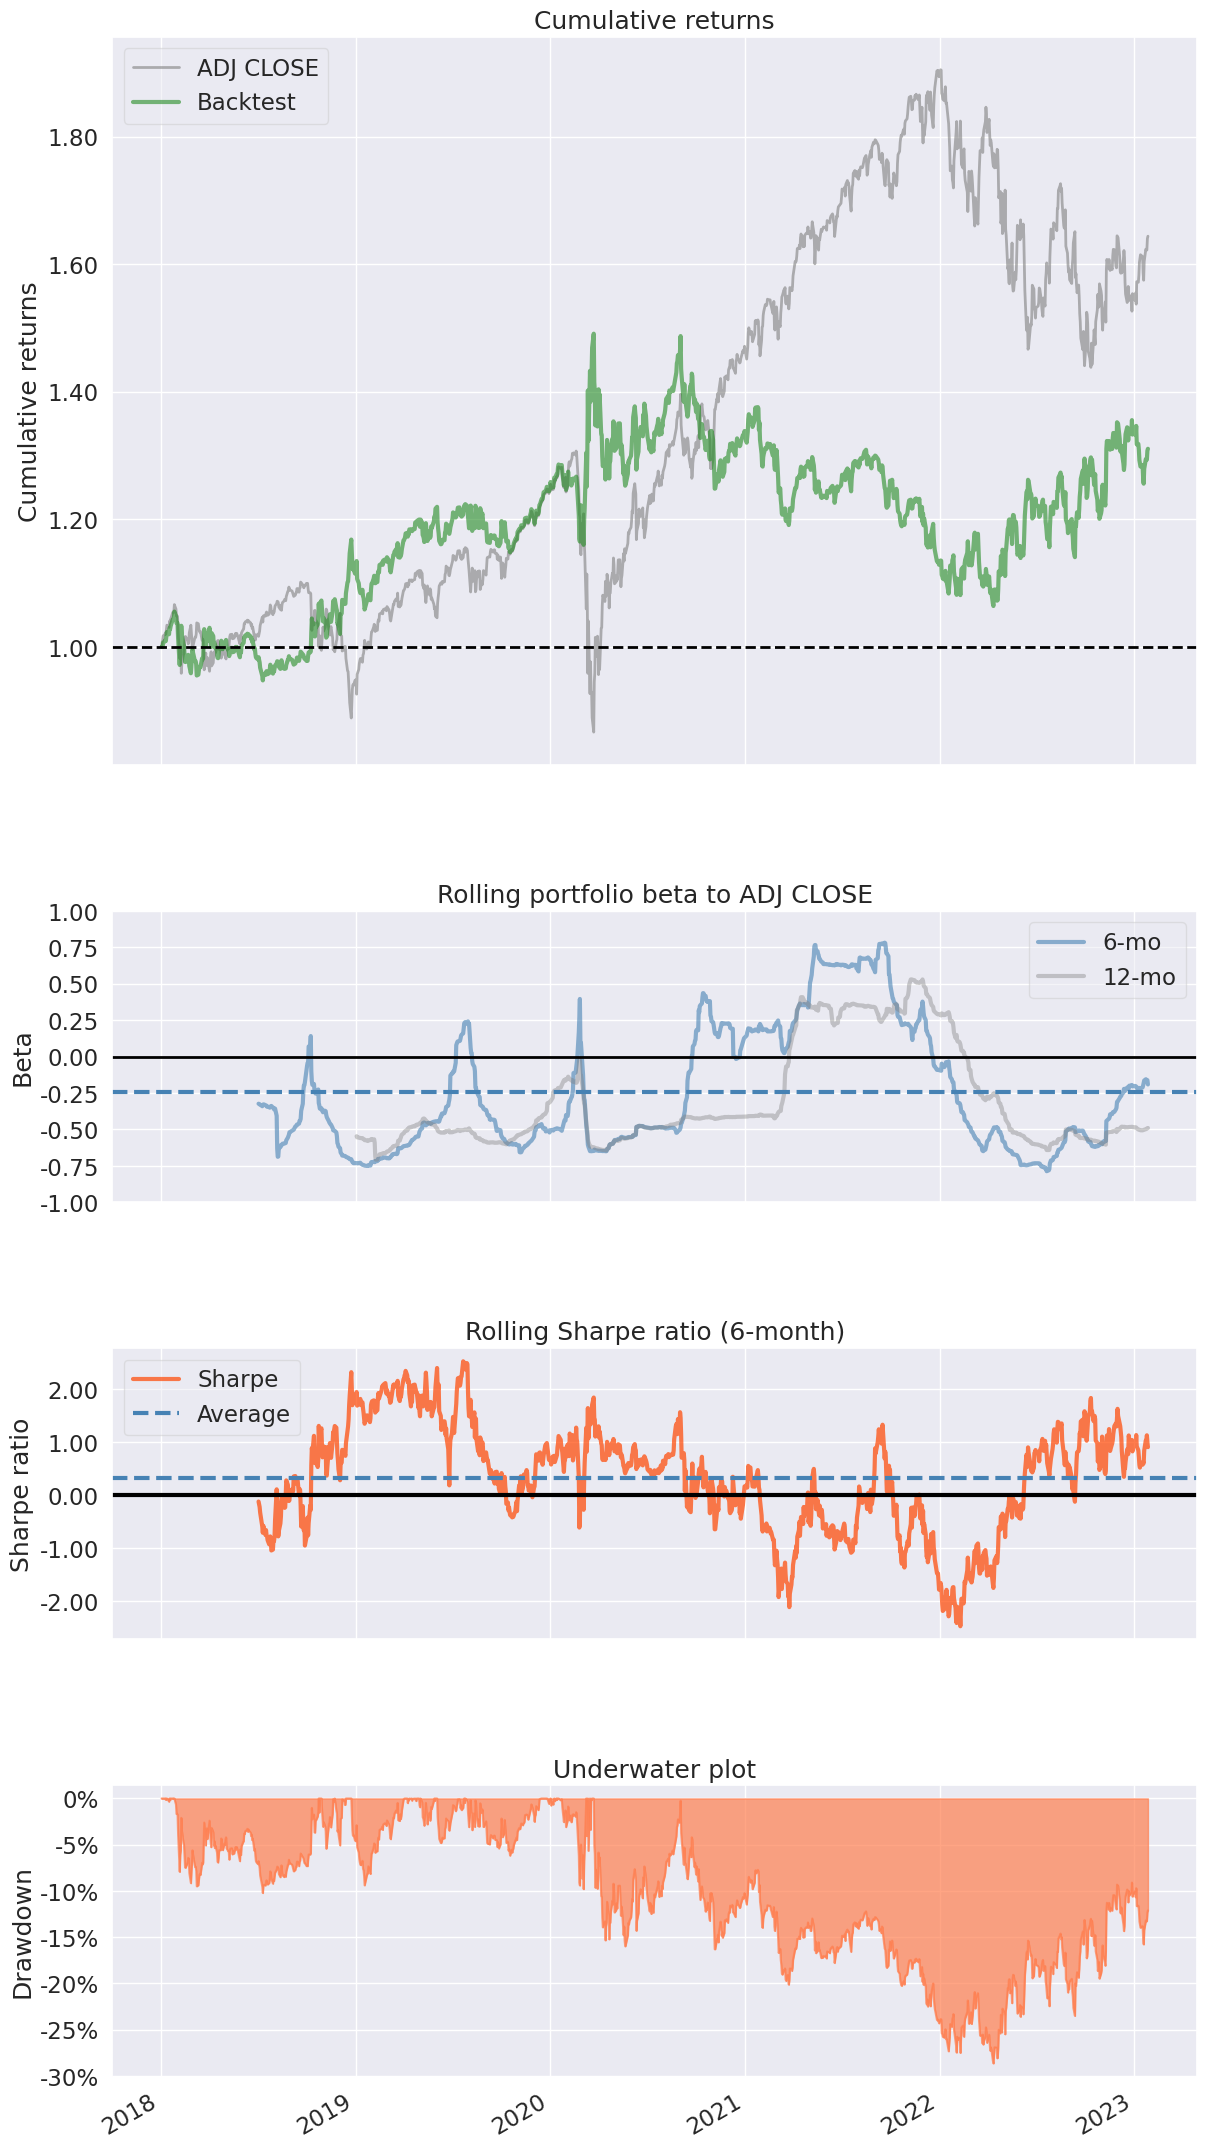

In [30]:
# Create benchmark daily returns for tearsheet analysis
def get_daily_returns(pnl_series, initial_capital):
    df = pnl_series.to_frame()
    df['cum_returns'] = df / initial_capital + 1
    df['daily_returns'] = df['cum_returns'].pct_change()
    return df['daily_returns']


spy_returns = backtest['ADJ CLOSE'].pct_change()
benchmark=spy_returns

initial_capital = 100_000   # used US$100,000 starting capital in my backtester program
#need to align mainsystem.portfolio_pnl index with spy returns index for benchmark_rets to work
returns=get_daily_returns(backtest['total_pnl'], initial_capital)[spy_returns.index]

# Create tearsheet
pyf.tears.create_simple_tear_sheet(returns, benchmark_rets=benchmark)

### 2. Backtest Results for Expanding-Window Model Fitting

In [31]:
# Read in backtest results csv file
filepath = f'./datasets/backtest_results/HMM_market_regimes_predictions_EW_backtest.csv'
backtest = pd.read_csv(filepath)

backtest.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
backtest['Date'] = pd.to_datetime(backtest.Date)
backtest.set_index('Date', inplace=True)
backtest

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,forecast,ideal_pos,close,fill_size,fill_price,total_buy,total_sell,average_buy_price,average_sell_price,unrealized_pnl,realized_pnl,total_pnl
Date,,,,,,,,,,,,,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,246.766617,86655700.0,10,0,246.766617,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,268.959991,270.640015,268.959991,270.470001,248.327469,90070400.0,10,405,248.327469,405,248.327469,405,0,248.327469,0.000000,0.000000,-0.000000,0.000000
2018-01-04,271.200012,272.160004,270.540009,271.609985,249.374069,80636400.0,-10,-402,249.374069,-807,249.374069,405,-807,248.327469,249.374069,-0.000000,423.873138,423.873138
2018-01-05,272.510010,273.559998,271.950012,273.420013,251.035965,83524000.0,10,402,251.035965,804,251.035965,1209,-807,250.128652,249.374069,364.739660,-608.948614,-244.208954
2018-01-08,273.309998,274.100006,272.980011,273.920013,251.495087,57319200.0,10,397,251.495087,0,0.000000,1209,-807,250.128652,249.374069,549.306585,-608.948614,-59.642029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800.0,10,265,400.630005,0,0.000000,17183,-16919,328.019310,327.251715,19169.223566,-12986.930277,6182.293289
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900.0,10,265,400.200012,0,0.000000,17183,-16919,328.019310,327.251715,19055.705499,-12986.930277,6068.775223
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300.0,10,265,400.350006,0,0.000000,17183,-16919,328.019310,327.251715,19095.303888,-12986.930277,6108.373611


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\plotting.py:648: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Start date,2018-01-02
End date,2023-01-27
Total months,60
,Backtest
Annual return,1.4%
Cumulative returns,7.5%
Annual volatility,18.9%
Sharpe ratio,0.17
Calmar ratio,0.03
Stability,0.12
Max drawdown,-45.3%


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\plotting.py:805: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



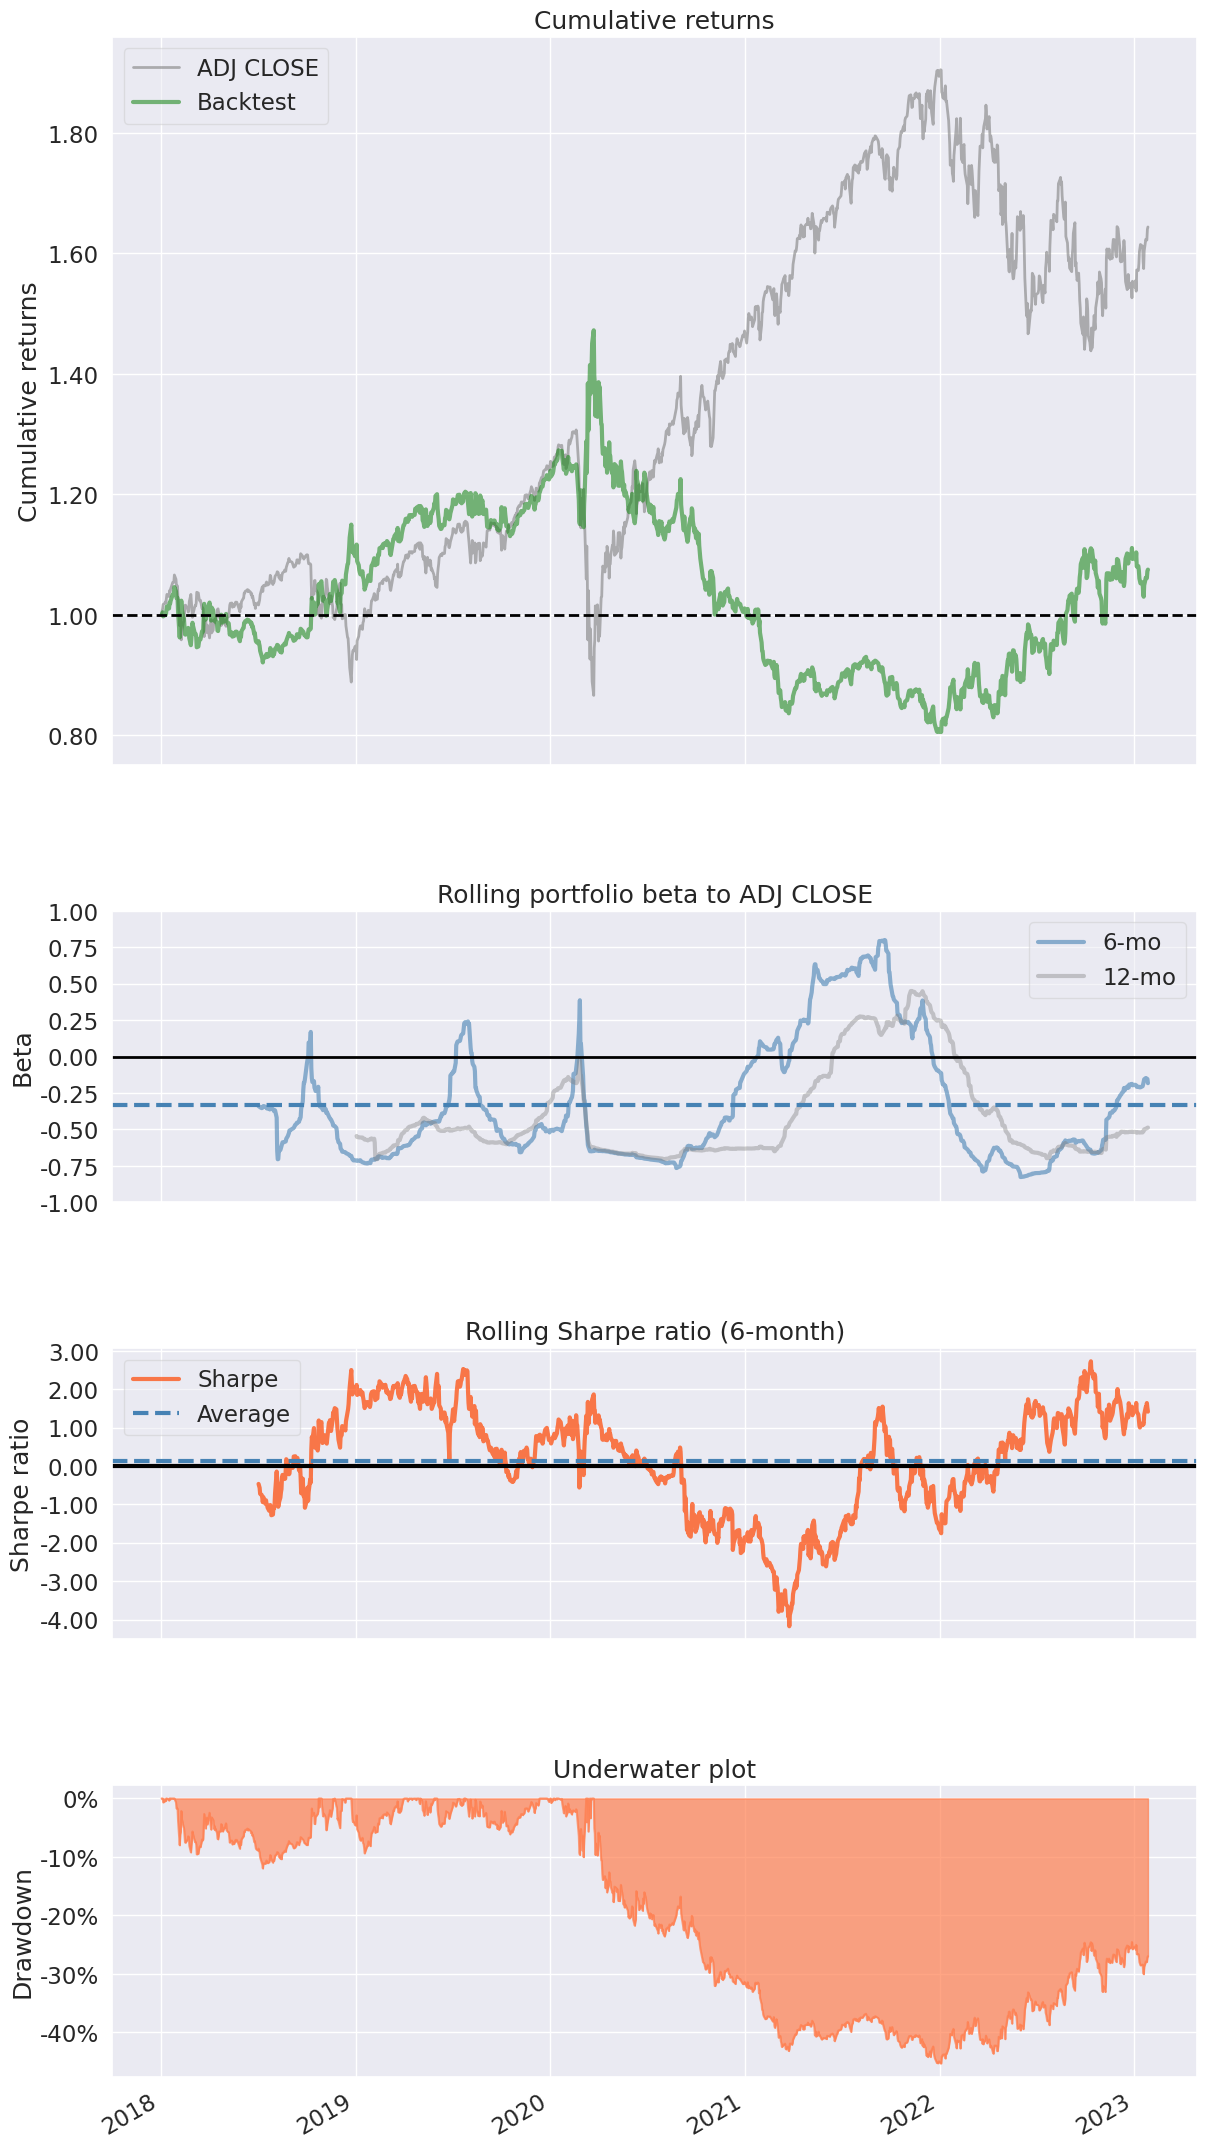

In [32]:
# Create benchmark daily returns for tearsheet analysis
def get_daily_returns(pnl_series, initial_capital):
    df = pnl_series.to_frame()
    df['cum_returns'] = df / initial_capital + 1
    df['daily_returns'] = df['cum_returns'].pct_change()
    return df['daily_returns']


spy_returns = backtest['ADJ CLOSE'].pct_change()
benchmark=spy_returns

initial_capital = 100_000   # used US$100,000 starting capital in my backtester program
#need to align mainsystem.portfolio_pnl index with spy returns index for benchmark_rets to work
returns=get_daily_returns(backtest['total_pnl'], initial_capital)[spy_returns.index]

# Create tearsheet
pyf.tears.create_simple_tear_sheet(returns, benchmark_rets=benchmark)

### 3. Backtest Results for Walk-Forward Window Model Fitting

In [33]:
# Read in backtest results csv file
filepath = f'./datasets/backtest_results/HMM_market_regimes_predictions_WF_backtest.csv'
backtest = pd.read_csv(filepath)

backtest.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
backtest['Date'] = pd.to_datetime(backtest.Date)
backtest.set_index('Date', inplace=True)
backtest

,OPEN,HIGH,LOW,CLOSE,ADJ CLOSE,VOLUME,forecast,ideal_pos,close,fill_size,fill_price,total_buy,total_sell,average_buy_price,average_sell_price,unrealized_pnl,realized_pnl,total_pnl
Date,,,,,,,,,,,,,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,246.766617,86655700.0,10,0,246.766617,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,268.959991,270.640015,268.959991,270.470001,248.327469,90070400.0,10,405,248.327469,405,248.327469,405,0,248.327469,0.000000,0.000000,-0.000000,0.000000
2018-01-04,271.200012,272.160004,270.540009,271.609985,249.374069,80636400.0,10,402,249.374069,0,0.000000,405,0,248.327469,0.000000,423.873138,-0.000000,423.873138
2018-01-05,272.510010,273.559998,271.950012,273.420013,251.035965,83524000.0,10,402,251.035965,0,0.000000,405,0,248.327469,0.000000,1096.940918,-0.000000,1096.940918
2018-01-08,273.309998,274.100006,272.980011,273.920013,251.495087,57319200.0,10,402,251.495087,0,0.000000,405,0,248.327469,0.000000,1282.885208,-0.000000,1282.885208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-23,396.720001,402.649994,395.720001,400.630005,400.630005,84178800.0,10,205,400.630005,0,0.000000,21541,-21337,315.170681,313.523197,17433.701972,-35152.372489,-17718.670517
2023-01-24,398.880005,401.149994,397.640015,400.200012,400.200012,59524900.0,10,205,400.200012,0,0.000000,21541,-21337,315.170681,313.523197,17345.983467,-35152.372489,-17806.389023
2023-01-25,395.950012,400.700012,393.559998,400.350006,400.350006,84800300.0,10,205,400.350006,0,0.000000,21541,-21337,315.170681,313.523197,17376.582221,-35152.372489,-17775.790268


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\plotting.py:648: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Start date,2018-01-02
End date,2023-01-27
Total months,60
,Backtest
Annual return,-3.5%
Cumulative returns,-16.7%
Annual volatility,18.7%
Sharpe ratio,-0.10
Calmar ratio,-0.08
Stability,0.53
Max drawdown,-44.4%


C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\plotting.py:805: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



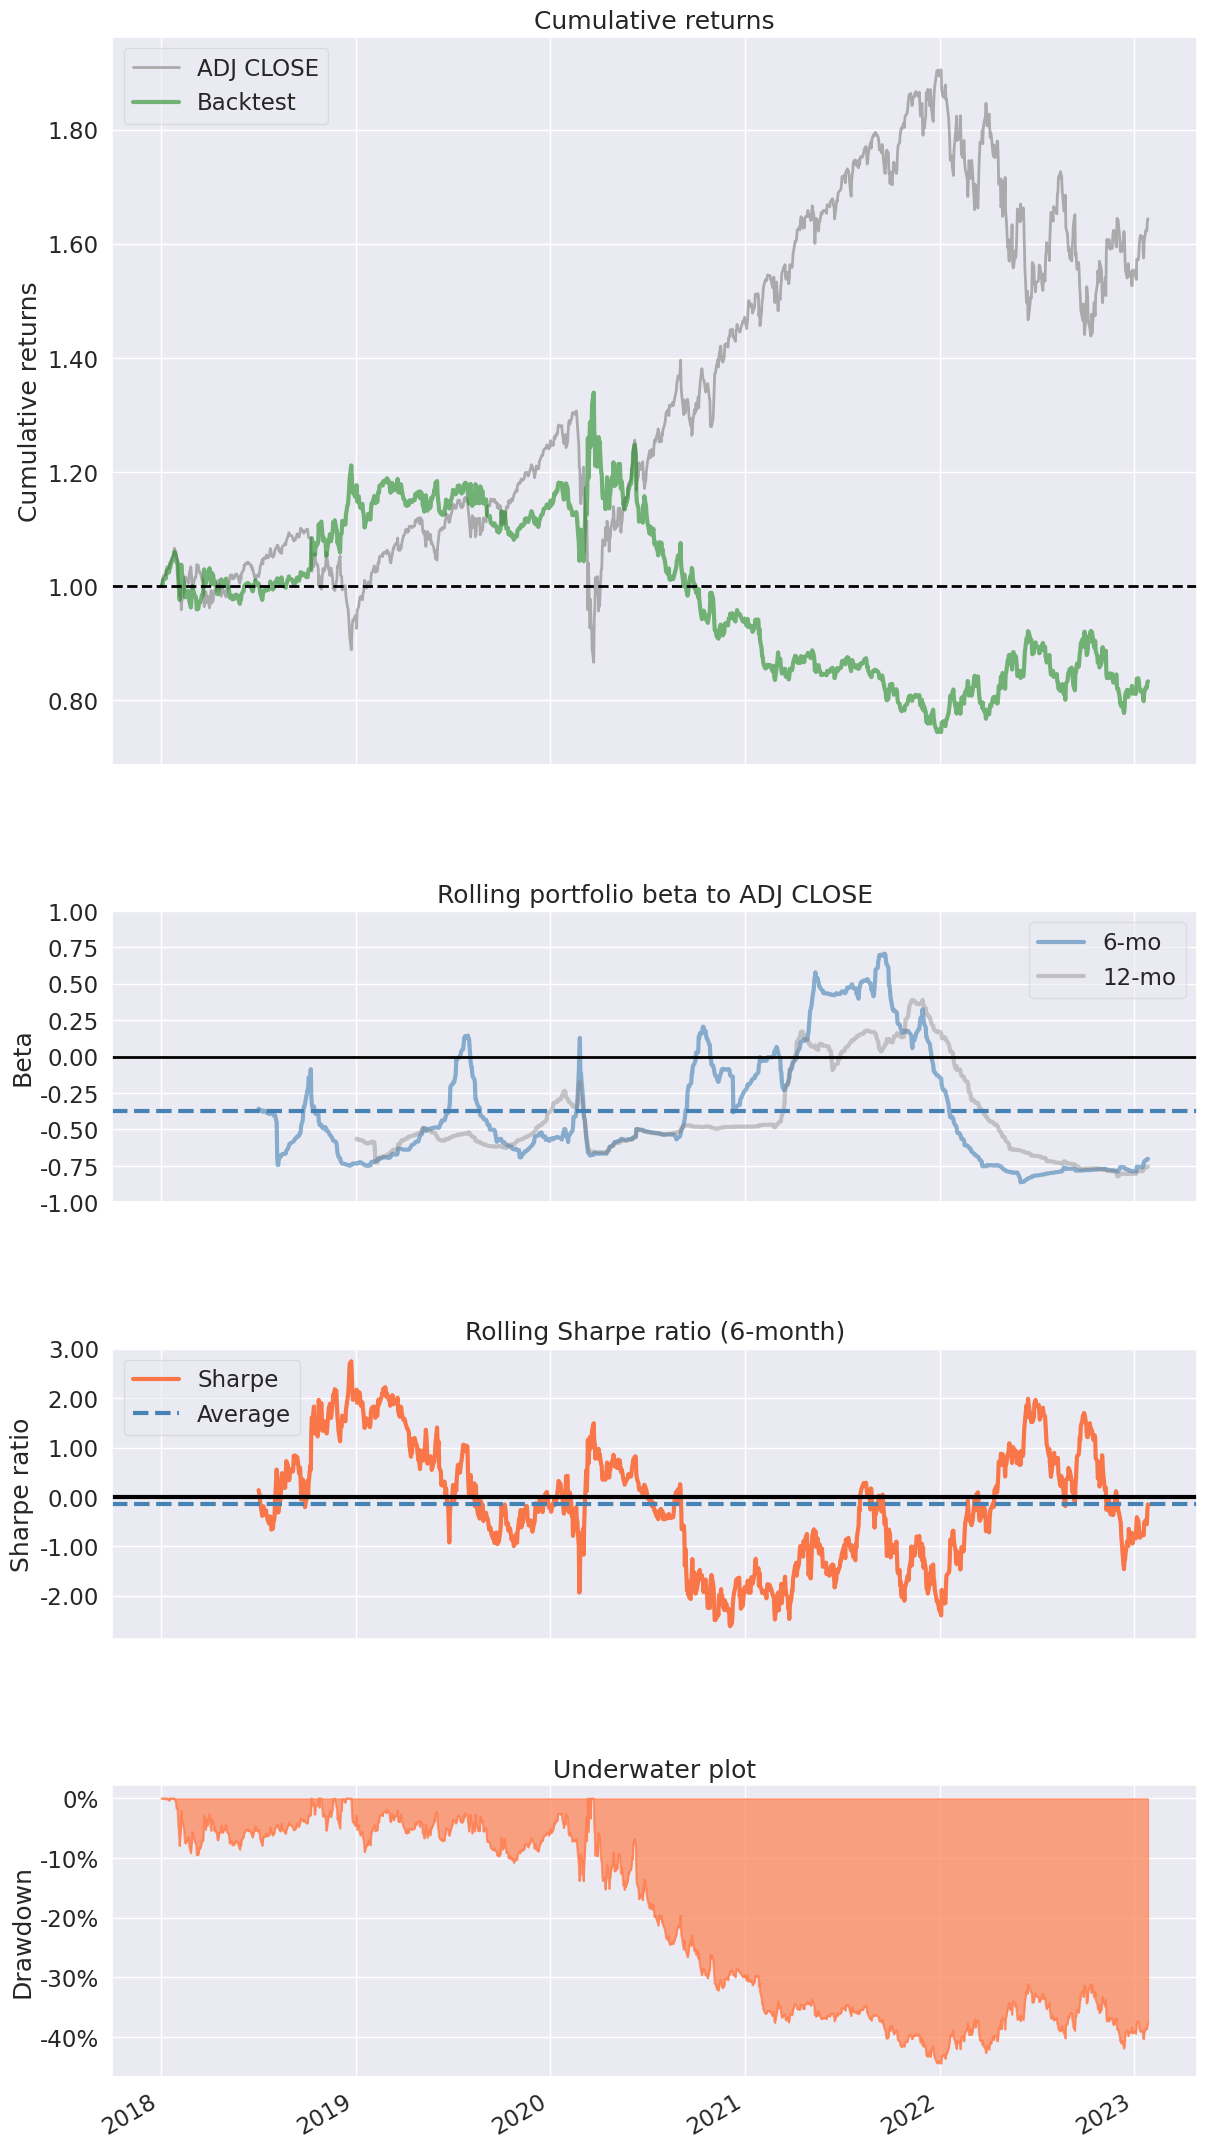

In [34]:
# Create benchmark daily returns for tearsheet analysis
def get_daily_returns(pnl_series, initial_capital):
    df = pnl_series.to_frame()
    df['cum_returns'] = df / initial_capital + 1
    df['daily_returns'] = df['cum_returns'].pct_change()
    return df['daily_returns']


spy_returns = backtest['ADJ CLOSE'].pct_change()
benchmark=spy_returns

initial_capital = 100_000   # used US$100,000 starting capital in my backtester program
#need to align mainsystem.portfolio_pnl index with spy returns index for benchmark_rets to work
returns=get_daily_returns(backtest['total_pnl'], initial_capital)[spy_returns.index]

# Create tearsheet
pyf.tears.create_simple_tear_sheet(returns, benchmark_rets=benchmark)